# 摂動法

`MNIST` の代わりに`FashionMNIST` を用いることもできる．MNISTは易しい課題であるため，MNISTを訓練できるからと言って複雑な課題でも機能する保証はない．とは言え，基本的なデータセットであるため，

In [1]:
using Base: @kwdef
using LinearAlgebra, Random, PyPlot, ProgressMeter, Statistics
using MLDatasets
include("../codes/neural_networks.jl")
rc("axes.spines", top=false, right=false)

In [20]:
trainset = MNIST(:train)
X_train, y_train = trainset[:]; # return all observations
println("X_train: $(size(X_train)), y_train: $(size( y_train))")

X_train: (28, 28, 60000), y_train: (60000,)


初回実行時はデータセットのダウンロードを行うか`[y/n]` (yes/no) の入力を求められるので`y`と入力する．

画像の空間次元はflattenする．また，labelは0-9の範囲から1-10の範囲に変更する．

In [4]:
# training data
n_traindata = length(trainset)
n_batch = 200 # batch size
n_iter_per_epoch = round(Int, n_traindata/n_batch)
n_epoch = 10; # number of epoch

X_train = Matrix(reshape(X_train[:, :, 1:n_traindata], (:, n_traindata))') 
y_train = y_train[1:n_traindata] .+ 1; # 0-9 to 1-10

モデルを定義する．

In [6]:
n_classes = 10
model = MLP([28^2, 128, 64, n_classes], [ReLU(), ReLU(), Softmax()]; init_type="He")
loss_fn = cross_entropy_loss!

lr = 1e-3  # learning rate
weight_decay = 1e-4 # weight decay (L2 norm) strength
optimizer = Adam(lr=lr);

Adam(0.001, 0.9, 0.999, 1.0e-8, Dict{Any, Any}(), Dict{Any, Any}())

訓練の途中で学習率を10分の1に減少させる．これを学習率スケジュール (learning rate schedule) という．機械学習においては学習率の変更には線形で減少させる方法，指数関数的に減少させる方法，学習率を振動させる方法 (cosine annealing schedule) などがある．

In [13]:
train_loss = zeros(n_epoch); #training loss of each epoch
for epoch in 1:n_epoch
    # learning rate schedule
    if epoch == round(Int, n_epoch/2)
        optimizer.lr *= 0.1
    end

    # shuffling data
    shuffle_indices = shuffle(1:n_traindata)
    X_train = X_train[shuffle_indices, :];
    y_train = y_train[shuffle_indices]

    # update
    for iter in 1:n_iter_per_epoch
        idx = (iter-1)*n_batch+1:iter*n_batch
        x, y = X_train[idx, :], y_train[idx]
        loss = train_step!(model, x, y, loss_fn, optimizer=optimizer, weight_decay=weight_decay)
        train_loss[epoch] += loss
    end
    train_loss[epoch] /= n_traindata
    println("[$(lpad(epoch, ndigits(n_epoch), '0'))/$(n_epoch)] train loss: $(train_loss[epoch])")
end

[01/10] train loss: 0.0006317448944782517
[02/10] train loss: 0.0005835164739585062
[03/10] train loss: 0.0005482185957361154
[04/10] train loss: 0.0005451264651738633
[05/10] train loss: 0.0002599244586183324
[06/10] train loss: 0.00021087877363006957
[07/10] train loss: 0.00018958617352342149
[08/10] train loss: 0.00017608858681054042
[09/10] train loss: 0.00016298981963793263
[10/10] train loss: 0.0001525681283255062


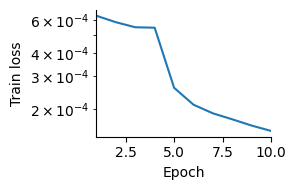

In [14]:
figure(figsize=(3,2))
semilogy(1:n_epoch, train_loss)
ylabel("Train loss"); xlabel("Epoch"); xlim(1, n_epoch)
tight_layout()

学習に使用しなかったデータを用いて，モデルの性能を確認しよう．

In [15]:
testset = MNIST(:test)
X_test, y_test = testset[:]
n_test = length(testset)

x_test = Matrix(reshape(X_test, (28^2, :))')
y_pred = model(x_test) # prediction (label probabilities)
t_pred = getindex.(argmax(y_pred, dims=2), 2) .- 1 # prediction of label
accuracy = sum(t_pred .== y_test) / n_test * 100
println("Test accuracy: $(accuracy)%")

Test accuracy: 97.95%


テストデータでの正答率は概ね98%となった．正答率を上げるには，モデルの中間層のユニットを増やす，Epoch数を増やす，データ拡張 (Data augmentation) を行う，等を行えば可能である．次に混同行列 (Confusion Matrix) を確認する．混同行列はサンプルごとの予測ラベルと正解ラベルを集計した2次元ヒストグラムであり，あるラベルのサンプルを別のラベルであると予測（混同）していないかを確認するものである．モデルの予測性能が高い場合は対角線上の値が大きくなる．

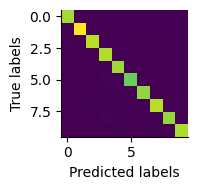

In [16]:
confusion_matrix = zeros(n_classes, n_classes)
for i in 1:n_test
    confusion_matrix[y_test[i]+1, t_pred[i]+1] += 1
end

figure(figsize=(2,2))
imshow(confusion_matrix)
xlabel("Predicted labels")
ylabel("True labels")
tight_layout()

最後に初期層の最初の36個の重みを確認する．

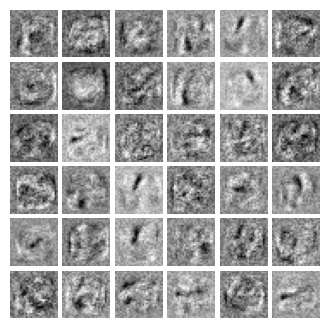

In [17]:
weights = reshape(model.W[1].v'[1:36, :], (36, 28, 28));

fig, axes = subplots(6, 6, figsize=(4,4))
axf = axes[:]
for i in 1:36
    axf[i].imshow(weights[i, :, :], cmap="gray")
    axf[i].axis("off")
end
subplots_adjust(hspace=0.1, wspace=0.1)